In [1]:
from fastai.vision.all import *
import torchaudio

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
DATA_PATH = Path('rfcx-species-audio-detection/')
train_df = pd.read_csv(DATA_PATH/'train_tp.csv')
train_files = get_files(DATA_PATH/'train', '.flac')

In [3]:
tfms = [torchaudio.transforms.MelSpectrogram(n_mels=6), torchaudio.transforms.AmplitudeToDB]
dls = DataBlock(blocks=(TransformBlock(type_tfms=tfms), MultiCategoryBlock),                   
                 get_x=lambda x: torchaudio.load(x)[0],
                 get_y=lambda x: set(train_df[train_df.recording_id == x.stem].species_id) or {24}).dataloaders(train_files, bs=16, num_workers=0)

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


In [4]:
learn = cnn_learner(dls, resnet18, config={"n_in":1}, metrics=[accuracy_multi])

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.03981071710586548)

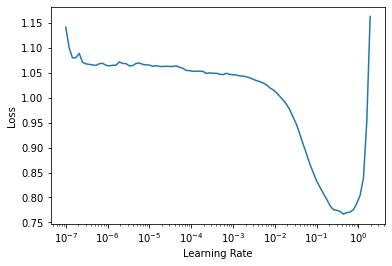

In [5]:
learn.lr_find()

In [6]:
learn.fine_tune(10, base_lr=4e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126082,0.096963,0.980106,19:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.082623,0.080975,0.980106,24:40
1,0.088730,0.081881,0.979598,24:40
2,0.081386,0.081905,0.979640,24:35
3,0.080311,0.076911,0.978667,24:30
4,0.077784,0.082187,0.980233,24:36
5,0.076212,0.270631,0.978582,24:35
6,0.069448,0.072856,0.980233,24:39
7,0.070300,0.070378,0.980360,24:47
8,0.064527,0.070657,0.979682,24:42
9,0.060642,0.069828,0.980190,26:12


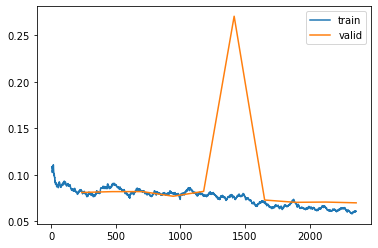

In [7]:
learn.recorder.plot_loss()

In [ ]:
learn = cnn_learner(dls, resnet18, config={"n_in":1}, metrics=[accuracy_multi])
learn.fit_one_cycle(10, 4e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.110349,0.101370,0.979809,21:07
1,0.096160,0.119613,0.980106,21:33
2,0.097569,0.093749,0.977143,20:45
3,0.097660,0.389634,0.974688,20:04
4,0.095165,2.743719,0.970836,19:33
5,0.085265,3.863962,0.971132,19:29
6,0.076302,2.767640,0.973418,21:22


In [ ]:
learn.recorder.plot_loss()

In [5]:
sample = pd.read_csv(DATA_PATH/'sample_submission.csv')
test_files = [DATA_PATH/'test'/f'{id}.flac' for id in sample.recording_id]

test_dl = dls.test_dl(test_files)
preds,_ = learn.get_preds(dl=test_dl)

submission = pd.concat([sample['recording_id'], pd.DataFrame(preds[:,:-1].numpy(), columns=sample.columns[1:])], axis=1)
submission

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,1.249995e-03,0.000803,0.000973,0.004964,0.002269,0.000974,0.001176,0.000378,0.000527,...,0.002288,0.002589,0.001138,0.000412,5.376231e-03,0.010492,0.000106,0.000684,0.002105,0.000067
1,003bc2cb2,4.352846e-07,0.005281,0.000002,0.003487,0.000007,0.000022,0.000018,0.000602,0.000062,...,0.000130,0.000661,0.097832,0.000975,4.654870e-07,0.000006,0.000106,0.000028,0.000003,0.000264
2,0061c037e,2.758876e-03,0.000632,0.000051,0.004161,0.000088,0.004711,0.002338,0.000738,0.000046,...,0.000041,0.000737,0.000453,0.000539,5.884307e-05,0.002360,0.000185,0.000116,0.017825,0.000932
3,010eb14d3,6.569891e-02,0.004385,0.000101,0.005767,0.001511,0.002161,0.001272,0.000787,0.002061,...,0.000037,0.000746,0.001780,0.000451,4.727647e-04,0.000904,0.000138,0.000546,0.003602,0.001082
4,011318064,2.735286e-04,0.000341,0.001531,0.003748,0.002871,0.001068,0.000201,0.000702,0.001003,...,0.042392,0.001586,0.000722,0.000241,8.447816e-03,0.000896,0.000050,0.002593,0.001074,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,4.646101e-04,0.001963,0.001547,0.005814,0.000276,0.008121,0.001396,0.017902,0.000714,...,0.000590,0.019099,0.000583,0.003465,3.392587e-05,0.004738,0.000365,0.000252,0.000900,0.503989
1988,ff973e852,1.456805e-04,0.000387,0.000236,0.008041,0.000234,0.001804,0.003155,0.033396,0.000112,...,0.000413,0.022686,0.005205,0.025355,6.766602e-05,0.006198,0.006770,0.000383,0.007580,0.000680
1989,ffa5cf6d6,8.771828e-04,0.000416,0.001171,0.011967,0.000395,0.002436,0.020088,0.003201,0.000123,...,0.000484,0.011452,0.004133,0.024108,4.462392e-04,0.027507,0.008075,0.000351,0.005381,0.000301
1990,ffa88cbb8,2.161760e-04,0.000293,0.000600,0.004001,0.000066,0.000293,0.000051,0.006341,0.000044,...,0.000052,0.016985,0.002729,0.000891,1.056889e-05,0.000947,0.000178,0.000251,0.001000,0.000051


In [6]:
submission.to_csv('submission.csv', index=False)

In [7]:
?torchaudio.transforms.MelSpectrogram